<a href="https://colab.research.google.com/github/Onedory/UROP_colorize_method/blob/main/3%2C%20AdaIN%2B%ED%86%B5%ED%95%A9%EB%AA%A8%EB%8D%B8_%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습에 필요한 라이브러리 불러오기 및 환경 설정

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

# 'transfo1rms'를 'transforms'로 수정
from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

논문의 핵심 아이디어 구현

① Instance Normalization을 위한 평균과 표준편차 계산

*   Instance Normalization을 구하기 위해 각 이미지의 매 채널에 대하여 평균(mean)과 표준편차(std) 값을 계산합니다.

*   Feature Map의 형태: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)


*   입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수입니다.


In [ ]:
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


논문의 핵심 아이디어 구현

② Adaptive Instance Normalization

*   본 논문에서 제시한 AdaIN을 구현합니다.

*   AdaIN은 content feature의 스타일을 style feature의 스타일로 변경하는 연산으로 이해할 수 있습니다


In [ ]:
def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


인코더 및 디코더 네트워크


*   인코더(Encoder): VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
*   디코더(Decoder): 인코더와 유사한 네트워크이지만 반대로 해상도(너비 X 높이)를 키우는 방식으로 동작합니다.



인코더(Encoder)



*   VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.





In [ ]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

디코더(Decoder)


*   디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
*   인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.



In [ ]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

사전 학습된(Pre-trained) 모델 불러오기

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2024-07-27 06:50:22--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-07-27 06:50:23--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  5.04MB/s    in 2.7s  

In [ ]:
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

AdaIN Style Transfer 네트워크
*   앞서 정의한 인코더와 디코더를 이용하는 하나의 네트워크를 정의합니다.
*   먼저 인코더(encoder)를 통해 feature map을 추출한 뒤에 AdaIN을 거쳐 Style Transfer를 수행합니다.
*   디코더는 처리된 feature를 입력받아 결과 이미지를 생성합니다.
*   본 실습에서 사용하지는 않지만 아키텍처를 이해하기 위해 코드를 확인해 봅시다.


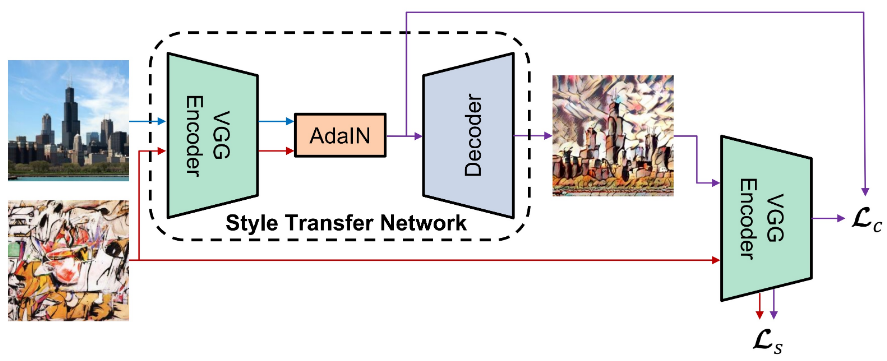

In [ ]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image (중간 결과를 기록)
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image (최종 결과만 기록)
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # 콘텐츠 손실(feature 값 자체가 유사해지도록)
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # 스타일 손실(feature의 statistics가 유사해지도록)
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        # 콘텐츠와 스타일 중 어떤 것에 더 많은 가중치를 둘지 설정 가능
        assert 0 <= alpha <= 1 # 0에 가까울수록 콘텐츠를 많이 살림
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t) # 결과 이미지
        g_t_feats = self.encode_with_intermediate(g_t)

        # 콘텐츠 손실과 스타일 손실을 줄이기 위해 두 개의 손실 값 반환
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

실습용 이미지 준비

In [ ]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 462 (delta 72), reused 185 (delta 62), pack-reused 261
Receiving objects: 100% (462/462), 53.71 MiB | 30.30 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


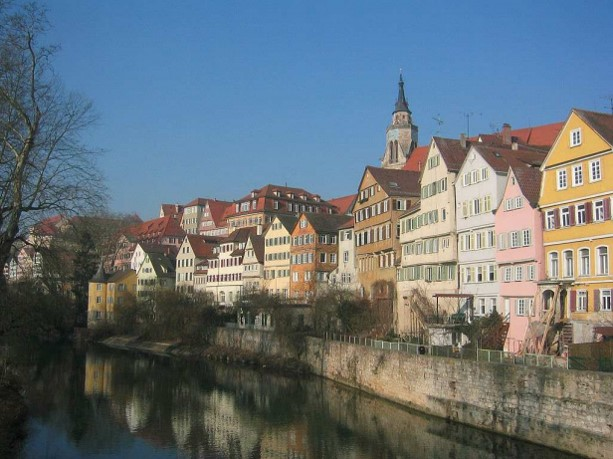

In [ ]:

# 콘텐츠(content) 이미지 출력
display_image('./code_practices/images/content_img_1.jpg')

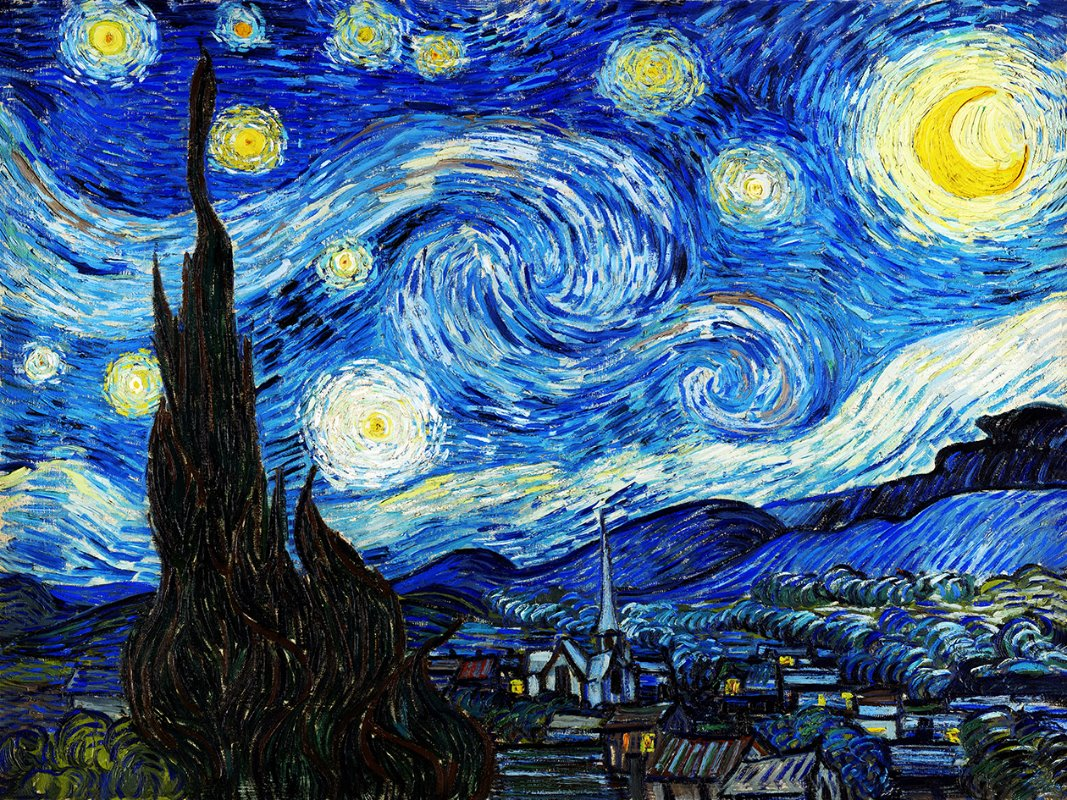

In [ ]:
# 스타일(style) 이미지 출력
display_image('./code_practices/images/style_img_1.jpg')

스타일 전송(style transfer)함수 구현

*   최종적인 style transfer 함수를 구현합니다.

In [ ]:
def style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)



*   이미지 전처리 함수를 구현합니다.



In [ ]:
def test_transform(size=512):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

content_tf = test_transform()
style_tf = test_transform()

Style Transfer 실습 ①
*   alpha 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.

In [ ]:
content_path = './code_practices/images/content_img_1.jpg'
style_path = './code_practices/images/style_img_1.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')


In [ ]:
# 결과 이미지 출력
display_image('./output.png')

Style Transfer 실습 ②

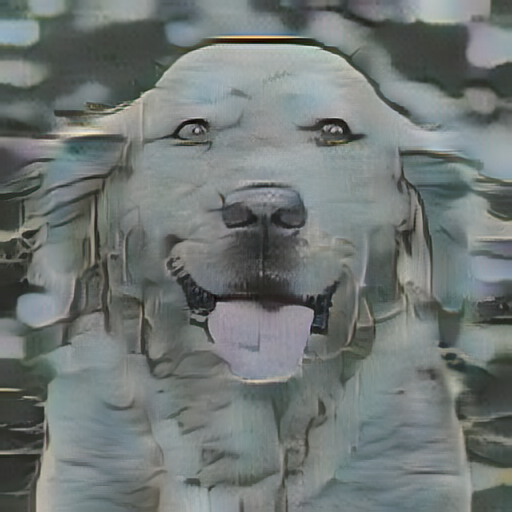

In [ ]:
content_path = './code_practices/images/content_img_2.jpg'
style_path = './code_practices/images/style_img_2.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')


# 결과 이미지 출력
display_image('./output.png')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from IPython.display import Image as display_image

# 계산을 위한 유틸리티 함수
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# VGG 네트워크와 디코더 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 사전 학습된 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])  # ReLU4_1까지만 사용

# 네트워크 정의
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

# 스타일 전이 함수 정의
def adain_style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# NST 스타일 전이 함수 (PyTorch로 수정)
def nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=200):
    content_targets = extractor.encode(content_image)
    style_targets = extractor.encode_with_intermediate(style_image)
    style_weight = 1000
    content_weight = 1

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        content_loss, style_loss = extractor(new_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}')

    return new_image

# 이미지 전처리 함수 정의
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)




--2024-08-20 08:10:01--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-08-20 08:10:02--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  4.54MB/s    in 2.9s  

<ipython-input-4-274073cbc074>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image = torch.tensor(adain_output.clone().detach())


Epoch 50/200, Content Loss: 0.5517077445983887, Style Loss: 0.12600727379322052
Epoch 100/200, Content Loss: 0.5517077445983887, Style Loss: 0.12600727379322052
Epoch 150/200, Content Loss: 0.5517077445983887, Style Loss: 0.12600727379322052
Epoch 200/200, Content Loss: 0.5517077445983887, Style Loss: 0.12600727379322052


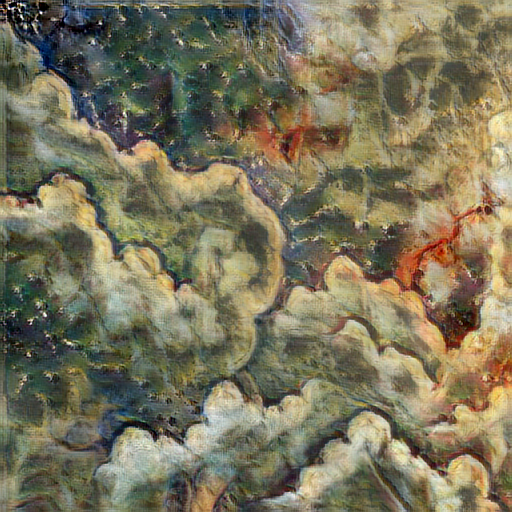

In [ ]:
# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/pink.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# Check if the file exists
import os
if not os.path.exists(style_image_path):
    print(f"Error: File not found at {style_image_path}")
else:
    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)

    # AdaIN 적용
    with torch.no_grad():
        adain_output = adain_style_transfer(vgg, decoder, content_image, style_image, alpha=1.0)

# NST 적용
extractor = Net(vgg, decoder).to(device)
# Remove requires_grad=True to prevent gradients from being computed for new_image
new_image = torch.tensor(adain_output.clone().detach())
optimizer = optim.Adam([new_image], lr=0.07)
final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=200)
# 최종 결과 출력
save_image(final_image, 'output.png')
display_image('output.png')

random search를 사용한 파라미터 최적화


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import os

# 파라미터 범위 정의
alpha_range = (0.0, 1.0)
content_weight_range = (0.1, 10.0)
style_weight_range = (10.0, 1000.0)
num_epochs_range = (100, 300)

# Random Search를 위한 실험 횟수 설정
n_trials = 10

best_loss = float('inf')
best_params = None

# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/pink.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'

# Check if the file exists
if not os.path.exists(style_image_path):
    print(f"Error: File not found at {style_image_path}")
else:
    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)

    # Random Search 수행
    for _ in range(n_trials):
        # 파라미터 랜덤 샘플링
        alpha = random.uniform(*alpha_range)
        content_weight = random.uniform(*content_weight_range)
        style_weight = random.uniform(*style_weight_range)
        num_epochs = random.randint(*num_epochs_range)

        print(f"Testing parameters: alpha={alpha}, content_weight={content_weight}, style_weight={style_weight}, num_epochs={num_epochs}")

        # 초기 이미지 생성 (AdaIN)
        with torch.no_grad():
            adain_output = adain_style_transfer(vgg, decoder, content_image, style_image, alpha=alpha)

        # NST 최적화
        extractor = Net(vgg, decoder).to(device)
        # Remove requires_grad=True to prevent gradients from being computed for new_image
        new_image = torch.tensor(adain_output.clone().detach())  # 수정된 부분: requires_grad=True 제거
        optimizer = optim.Adam([new_image], lr=0.07)

        final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=num_epochs)

        # 평가 지표 계산 (예: 콘텐츠 손실 + 스타일 손실)
        content_loss, style_loss = extractor(final_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss

        # 최적의 파라미터 저장
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_params = (alpha, content_weight, style_weight, num_epochs)
            save_image(final_image, 'best_output_random_search.png')  # 최적 결과 저장

    print(f"Best parameters found by Random Search: {best_params}")
    display_image('best_output_random_search.png')


Testing parameters: alpha=0.31612545665683023, content_weight=4.279658284021363, style_weight=735.5032692769857, num_epochs=171


<ipython-input-14-36da6323be9a>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_image = torch.tensor(adain_output.clone().detach())  # 수정된 부분: requires_grad=True 제거


Epoch 50/171, Content Loss: 0.814365565776825, Style Loss: 0.11653819680213928
Epoch 100/171, Content Loss: 0.814365565776825, Style Loss: 0.11653819680213928
Epoch 150/171, Content Loss: 0.814365565776825, Style Loss: 0.11653819680213928
Testing parameters: alpha=0.8535228035633257, content_weight=1.979984613550815, style_weight=628.8658886370712, num_epochs=298
Epoch 50/298, Content Loss: 0.5537678003311157, Style Loss: 0.12428492307662964
Epoch 100/298, Content Loss: 0.5537678003311157, Style Loss: 0.12428492307662964
Epoch 150/298, Content Loss: 0.5537678003311157, Style Loss: 0.12428492307662964
Epoch 200/298, Content Loss: 0.5537678003311157, Style Loss: 0.12428492307662964
Epoch 250/298, Content Loss: 0.5537678003311157, Style Loss: 0.12428492307662964
Testing parameters: alpha=0.12638302471284946, content_weight=7.372275707275127, style_weight=288.43709929506076, num_epochs=282
Epoch 50/282, Content Loss: 0.9839909076690674, Style Loss: 0.12388209253549576
Epoch 100/282, Conten

최적화된 스타일 전이 통합 모델쓰~

--2024-08-20 09:29:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1 [following]
--2024-08-20 09:29:27--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 14023458 (13M) [application/octet-stream]
Saving to: ‘decoder.pth’

decoder.pth         100%[===================>]  13.37M  4.65MB/s    in 2.9s  

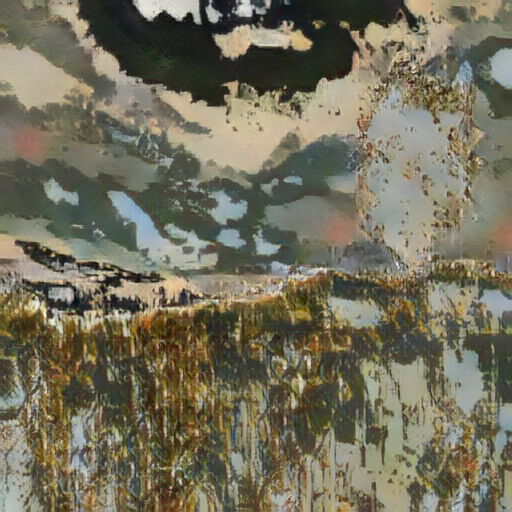

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
from IPython.display import Image as display_image

# 계산을 위한 유틸리티 함수
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

# VGG 네트워크와 디코더 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

# 사전 학습된 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31])  # ReLU4_1까지만 사용

# 네트워크 정의
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=0.4238):  # 최적화된 alpha 적용
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

# 스타일 전이 함수 정의
def adain_style_transfer(vgg, decoder, content, style, alpha=0.4238):  # 최적화된 alpha 적용
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

# NST 스타일 전이 함수 (PyTorch로 수정)
def nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=207):  # 최적화된 num_epochs 적용
    content_targets = extractor.encode(content_image)
    style_targets = extractor.encode_with_intermediate(style_image)
    style_weight = 150.1599  # 최적화된 style_weight 적용
    content_weight = 2.6485  # 최적화된 content_weight 적용

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        content_loss, style_loss = extractor(new_image, style_image)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}')

    return new_image

# 이미지 전처리 함수 정의
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

# 이미지 로드 및 전처리
content_image_path = '/content/drive/MyDrive/UROP/colorized_with_ahm.png'
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_5.png'

# Check if the file exists
import os
if not os.path.exists(style_image_path):
    print(f"Error: File not found at {style_image_path}")
else:
    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)

    # AdaIN 적용
    with torch.no_grad():
        adain_output = adain_style_transfer(vgg, decoder, content_image, style_image)
# NST 적용
extractor = Net(vgg, decoder).to(device)
# Initialize new_image without requiring gradients
new_image = adain_output.clone().detach()
optimizer = optim.Adam([new_image], lr=0.07)

# Remove the torch.no_grad() context manager
final_image = nst_style_transfer(extractor, content_image, style_image, new_image, optimizer, num_epochs=207)
# 최종 결과 출력
save_image(final_image, '/content/drive/MyDrive/UROP/output_optimize.png')
display_image('/content/drive/MyDrive/UROP/output_optimize.png')
